In [1]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from densenet201 import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit_dpd import IEViT
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from cam_generate import cam_generate
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
# device = torch.device("cuda:0")
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
# patch_size = 16p
patch_size = 32
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../../mured-data/data'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim)
# create an instance of IEVIT
model = IEViT(img_size= image_size, patch_size = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim,
               num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels, 0)
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels,1)
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()      

Epoch 1/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [1/200], Loss: 0.2032, ML mAP: 0.1109, ML F1: 0.0400, ML AUC: 0.5716, ML Score: 0.3413, Bin AUC: 0.6316, Model Score: 0.4864, Bin F1: 0.1667


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [1/200], Loss: 0.2032, ML mAP: 0.2228, ML F1: 0.0183, ML AUC: 0.8076, ML Score: 0.5152, Bin AUC: 0.4211, Model Score: 0.4681, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [2/200], Loss: 0.2634, ML mAP: 0.2396, ML F1: 0.1062, ML AUC: 0.7679, ML Score: 0.5037, Bin AUC: 0.4706, Model Score: 0.4872, Bin F1: 0.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [2/200], Loss: 0.2634, ML mAP: 0.3550, ML F1: 0.1079, ML AUC: 0.8742, ML Score: 0.6146, Bin AUC: 0.6842, Model Score: 0.6494, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [3/200], Loss: 0.1779, ML mAP: 0.3461, ML F1: 0.2103, ML AUC: 0.8369, ML Score: 0.5915, Bin AUC: 0.8947, Model Score: 0.7431, Bin F1: 0.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [3/200], Loss: 0.1779, ML mAP: 0.4658, ML F1: 0.1486, ML AUC: 0.8973, ML Score: 0.6815, Bin AUC: 0.9474, Model Score: 0.8144, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [4/200], Loss: 0.2229, ML mAP: 0.5024, ML F1: 0.3740, ML AUC: 0.8911, ML Score: 0.6967, Bin AUC: 0.9474, Model Score: 0.8221, Bin F1: 0.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [4/200], Loss: 0.2229, ML mAP: 0.5205, ML F1: 0.2351, ML AUC: 0.9099, ML Score: 0.7152, Bin AUC: 0.4211, Model Score: 0.5681, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [5/200], Loss: 0.1313, ML mAP: 0.5973, ML F1: 0.4849, ML AUC: 0.9190, ML Score: 0.7582, Bin AUC: 1.0000, Model Score: 0.8791, Bin F1: 0.8000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [5/200], Loss: 0.1313, ML mAP: 0.5731, ML F1: 0.3562, ML AUC: 0.9216, ML Score: 0.7473, Bin AUC: 0.2105, Model Score: 0.4789, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [6/200], Loss: 0.2085, ML mAP: 0.6603, ML F1: 0.5628, ML AUC: 0.9323, ML Score: 0.7963, Bin AUC: 0.9474, Model Score: 0.8718, Bin F1: 0.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [6/200], Loss: 0.2085, ML mAP: 0.5951, ML F1: 0.5002, ML AUC: 0.9208, ML Score: 0.7580, Bin AUC: 0.5789, Model Score: 0.6685, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [7/200], Loss: 0.2462, ML mAP: 0.7475, ML F1: 0.6323, ML AUC: 0.9563, ML Score: 0.8519, Bin AUC: 1.0000, Model Score: 0.9260, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [7/200], Loss: 0.2462, ML mAP: 0.6036, ML F1: 0.4705, ML AUC: 0.9177, ML Score: 0.7607, Bin AUC: 0.3158, Model Score: 0.5382, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [8/200], Loss: 0.1823, ML mAP: 0.7916, ML F1: 0.6892, ML AUC: 0.9616, ML Score: 0.8766, Bin AUC: 0.9167, Model Score: 0.8966, Bin F1: 0.4000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [8/200], Loss: 0.1823, ML mAP: 0.6039, ML F1: 0.4823, ML AUC: 0.9250, ML Score: 0.7644, Bin AUC: 0.3684, Model Score: 0.5664, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [9/200], Loss: 0.1590, ML mAP: 0.8020, ML F1: 0.6966, ML AUC: 0.9683, ML Score: 0.8852, Bin AUC: 1.0000, Model Score: 0.9426, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [9/200], Loss: 0.1590, ML mAP: 0.6107, ML F1: 0.4552, ML AUC: 0.9274, ML Score: 0.7690, Bin AUC: 0.5789, Model Score: 0.6740, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [10/200], Loss: 0.2114, ML mAP: 0.8191, ML F1: 0.7110, ML AUC: 0.9690, ML Score: 0.8941, Bin AUC: 1.0000, Model Score: 0.9470, Bin F1: 0.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [10/200], Loss: 0.2114, ML mAP: 0.6235, ML F1: 0.4816, ML AUC: 0.9292, ML Score: 0.7763, Bin AUC: 0.3158, Model Score: 0.5461, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [11/200], Loss: 0.1259, ML mAP: 0.7364, ML F1: 0.6640, ML AUC: 0.9532, ML Score: 0.8448, Bin AUC: 0.9804, Model Score: 0.9126, Bin F1: 0.8000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [11/200], Loss: 0.1259, ML mAP: 0.6225, ML F1: 0.5352, ML AUC: 0.9271, ML Score: 0.7748, Bin AUC: 0.2632, Model Score: 0.5190, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [12/200], Loss: 0.0638, ML mAP: 0.7495, ML F1: 0.6762, ML AUC: 0.9552, ML Score: 0.8523, Bin AUC: 1.0000, Model Score: 0.9262, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [12/200], Loss: 0.0638, ML mAP: 0.6254, ML F1: 0.5089, ML AUC: 0.9185, ML Score: 0.7719, Bin AUC: 0.4737, Model Score: 0.6228, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [13/200], Loss: 0.2027, ML mAP: 0.8106, ML F1: 0.7399, ML AUC: 0.9681, ML Score: 0.8894, Bin AUC: 1.0000, Model Score: 0.9447, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [13/200], Loss: 0.2027, ML mAP: 0.6240, ML F1: 0.5435, ML AUC: 0.9224, ML Score: 0.7732, Bin AUC: 0.6316, Model Score: 0.7024, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [14/200], Loss: 0.2262, ML mAP: 0.8432, ML F1: 0.7714, ML AUC: 0.9746, ML Score: 0.9089, Bin AUC: 0.9804, Model Score: 0.9446, Bin F1: 0.8000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [14/200], Loss: 0.2262, ML mAP: 0.6238, ML F1: 0.4888, ML AUC: 0.9192, ML Score: 0.7715, Bin AUC: 0.4737, Model Score: 0.6226, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [15/200], Loss: 0.0969, ML mAP: 0.8791, ML F1: 0.8145, ML AUC: 0.9791, ML Score: 0.9291, Bin AUC: 0.9722, Model Score: 0.9507, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [15/200], Loss: 0.0969, ML mAP: 0.6318, ML F1: 0.5252, ML AUC: 0.9291, ML Score: 0.7805, Bin AUC: 0.7368, Model Score: 0.7587, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [16/200], Loss: 0.2625, ML mAP: 0.8944, ML F1: 0.8331, ML AUC: 0.9840, ML Score: 0.9392, Bin AUC: 0.9444, Model Score: 0.9418, Bin F1: 0.5000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [16/200], Loss: 0.2625, ML mAP: 0.6099, ML F1: 0.4962, ML AUC: 0.9282, ML Score: 0.7691, Bin AUC: 0.2105, Model Score: 0.4898, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [17/200], Loss: 0.0484, ML mAP: 0.8994, ML F1: 0.8400, ML AUC: 0.9853, ML Score: 0.9423, Bin AUC: 1.0000, Model Score: 0.9712, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [17/200], Loss: 0.0484, ML mAP: 0.6113, ML F1: 0.5059, ML AUC: 0.9255, ML Score: 0.7684, Bin AUC: 0.4737, Model Score: 0.6211, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [18/200], Loss: 0.0453, ML mAP: 0.9304, ML F1: 0.8680, ML AUC: 0.9884, ML Score: 0.9594, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [18/200], Loss: 0.0453, ML mAP: 0.6253, ML F1: 0.5339, ML AUC: 0.9239, ML Score: 0.7746, Bin AUC: 0.5263, Model Score: 0.6504, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [19/200], Loss: 0.1768, ML mAP: 0.9383, ML F1: 0.8887, ML AUC: 0.9909, ML Score: 0.9646, Bin AUC: 0.9474, Model Score: 0.9560, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [19/200], Loss: 0.1768, ML mAP: 0.6221, ML F1: 0.5285, ML AUC: 0.9251, ML Score: 0.7736, Bin AUC: 0.7895, Model Score: 0.7815, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [20/200], Loss: 0.0823, ML mAP: 0.9515, ML F1: 0.8954, ML AUC: 0.9929, ML Score: 0.9722, Bin AUC: 1.0000, Model Score: 0.9861, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [20/200], Loss: 0.0823, ML mAP: 0.6337, ML F1: 0.5508, ML AUC: 0.9293, ML Score: 0.7815, Bin AUC: 0.8947, Model Score: 0.8381, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [21/200], Loss: 0.0770, ML mAP: 0.9605, ML F1: 0.9108, ML AUC: 0.9944, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [21/200], Loss: 0.0770, ML mAP: 0.6275, ML F1: 0.5791, ML AUC: 0.9229, ML Score: 0.7752, Bin AUC: 0.7368, Model Score: 0.7560, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [22/200], Loss: 0.0182, ML mAP: 0.9671, ML F1: 0.9184, ML AUC: 0.9956, ML Score: 0.9814, Bin AUC: 1.0000, Model Score: 0.9907, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [22/200], Loss: 0.0182, ML mAP: 0.6209, ML F1: 0.5618, ML AUC: 0.9189, ML Score: 0.7699, Bin AUC: 0.8947, Model Score: 0.8323, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [23/200], Loss: 0.1086, ML mAP: 0.9692, ML F1: 0.9297, ML AUC: 0.9960, ML Score: 0.9826, Bin AUC: 1.0000, Model Score: 0.9913, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [23/200], Loss: 0.1086, ML mAP: 0.6337, ML F1: 0.5502, ML AUC: 0.9252, ML Score: 0.7795, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [24/200], Loss: 0.0631, ML mAP: 0.9704, ML F1: 0.9320, ML AUC: 0.9964, ML Score: 0.9834, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [24/200], Loss: 0.0631, ML mAP: 0.6273, ML F1: 0.5539, ML AUC: 0.9201, ML Score: 0.7737, Bin AUC: 0.9474, Model Score: 0.8605, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [25/200], Loss: 0.0743, ML mAP: 0.9788, ML F1: 0.9415, ML AUC: 0.9974, ML Score: 0.9881, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [25/200], Loss: 0.0743, ML mAP: 0.6189, ML F1: 0.5632, ML AUC: 0.9248, ML Score: 0.7719, Bin AUC: 0.8421, Model Score: 0.8070, Bin F1: 0.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [26/200], Loss: 0.0075, ML mAP: 0.9815, ML F1: 0.9486, ML AUC: 0.9977, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [26/200], Loss: 0.0075, ML mAP: 0.6212, ML F1: 0.5359, ML AUC: 0.9239, ML Score: 0.7725, Bin AUC: 0.8947, Model Score: 0.8336, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [27/200], Loss: 0.0360, ML mAP: 0.9793, ML F1: 0.9489, ML AUC: 0.9971, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [27/200], Loss: 0.0360, ML mAP: 0.6305, ML F1: 0.5635, ML AUC: 0.9233, ML Score: 0.7769, Bin AUC: 0.8947, Model Score: 0.8358, Bin F1: 0.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [28/200], Loss: 0.0048, ML mAP: 0.9880, ML F1: 0.9638, ML AUC: 0.9985, ML Score: 0.9932, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [28/200], Loss: 0.0048, ML mAP: 0.6316, ML F1: 0.5669, ML AUC: 0.9249, ML Score: 0.7783, Bin AUC: 0.8421, Model Score: 0.8102, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [29/200], Loss: 0.0584, ML mAP: 0.9816, ML F1: 0.9540, ML AUC: 0.9974, ML Score: 0.9895, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [29/200], Loss: 0.0584, ML mAP: 0.6282, ML F1: 0.5648, ML AUC: 0.9258, ML Score: 0.7770, Bin AUC: 0.8947, Model Score: 0.8359, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [30/200], Loss: 0.0194, ML mAP: 0.9828, ML F1: 0.9478, ML AUC: 0.9980, ML Score: 0.9904, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [30/200], Loss: 0.0194, ML mAP: 0.6321, ML F1: 0.5622, ML AUC: 0.9249, ML Score: 0.7785, Bin AUC: 0.8421, Model Score: 0.8103, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [31/200], Loss: 0.0678, ML mAP: 0.9510, ML F1: 0.9089, ML AUC: 0.9939, ML Score: 0.9724, Bin AUC: 1.0000, Model Score: 0.9862, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [31/200], Loss: 0.0678, ML mAP: 0.6220, ML F1: 0.5193, ML AUC: 0.9228, ML Score: 0.7724, Bin AUC: 0.4737, Model Score: 0.6230, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [32/200], Loss: 0.0747, ML mAP: 0.9379, ML F1: 0.8800, ML AUC: 0.9922, ML Score: 0.9650, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [32/200], Loss: 0.0747, ML mAP: 0.6296, ML F1: 0.5589, ML AUC: 0.9175, ML Score: 0.7736, Bin AUC: 0.7368, Model Score: 0.7552, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [33/200], Loss: 0.0718, ML mAP: 0.9472, ML F1: 0.8959, ML AUC: 0.9929, ML Score: 0.9701, Bin AUC: 1.0000, Model Score: 0.9850, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [33/200], Loss: 0.0718, ML mAP: 0.6217, ML F1: 0.5273, ML AUC: 0.9249, ML Score: 0.7733, Bin AUC: 0.6316, Model Score: 0.7024, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [34/200], Loss: 0.2034, ML mAP: 0.9480, ML F1: 0.8913, ML AUC: 0.9937, ML Score: 0.9708, Bin AUC: 1.0000, Model Score: 0.9854, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [34/200], Loss: 0.2034, ML mAP: 0.6444, ML F1: 0.5599, ML AUC: 0.9275, ML Score: 0.7860, Bin AUC: 0.6316, Model Score: 0.7088, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [35/200], Loss: 0.0627, ML mAP: 0.9517, ML F1: 0.9046, ML AUC: 0.9937, ML Score: 0.9727, Bin AUC: 1.0000, Model Score: 0.9864, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [35/200], Loss: 0.0627, ML mAP: 0.6287, ML F1: 0.5633, ML AUC: 0.9212, ML Score: 0.7750, Bin AUC: 0.8421, Model Score: 0.8085, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [36/200], Loss: 0.0197, ML mAP: 0.9654, ML F1: 0.9232, ML AUC: 0.9954, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [36/200], Loss: 0.0197, ML mAP: 0.6350, ML F1: 0.5867, ML AUC: 0.9204, ML Score: 0.7777, Bin AUC: 0.7368, Model Score: 0.7573, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [37/200], Loss: 0.2089, ML mAP: 0.9742, ML F1: 0.9272, ML AUC: 0.9968, ML Score: 0.9855, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [37/200], Loss: 0.2089, ML mAP: 0.6276, ML F1: 0.5506, ML AUC: 0.9166, ML Score: 0.7721, Bin AUC: 0.6316, Model Score: 0.7018, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [38/200], Loss: 0.1511, ML mAP: 0.9653, ML F1: 0.9202, ML AUC: 0.9954, ML Score: 0.9803, Bin AUC: 0.9688, Model Score: 0.9745, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [38/200], Loss: 0.1511, ML mAP: 0.6317, ML F1: 0.5657, ML AUC: 0.9249, ML Score: 0.7783, Bin AUC: 0.5789, Model Score: 0.6786, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [39/200], Loss: 0.1636, ML mAP: 0.9669, ML F1: 0.9237, ML AUC: 0.9951, ML Score: 0.9810, Bin AUC: 1.0000, Model Score: 0.9905, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [39/200], Loss: 0.1636, ML mAP: 0.6531, ML F1: 0.5960, ML AUC: 0.9258, ML Score: 0.7895, Bin AUC: 0.6842, Model Score: 0.7368, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [40/200], Loss: 0.0053, ML mAP: 0.9658, ML F1: 0.9198, ML AUC: 0.9958, ML Score: 0.9808, Bin AUC: 1.0000, Model Score: 0.9904, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [40/200], Loss: 0.0053, ML mAP: 0.6430, ML F1: 0.5713, ML AUC: 0.9312, ML Score: 0.7871, Bin AUC: 0.5263, Model Score: 0.6567, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [41/200], Loss: 0.0972, ML mAP: 0.9742, ML F1: 0.9335, ML AUC: 0.9967, ML Score: 0.9854, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [41/200], Loss: 0.0972, ML mAP: 0.6472, ML F1: 0.5831, ML AUC: 0.9312, ML Score: 0.7892, Bin AUC: 0.6842, Model Score: 0.7367, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [42/200], Loss: 0.0398, ML mAP: 0.9797, ML F1: 0.9433, ML AUC: 0.9974, ML Score: 0.9885, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [42/200], Loss: 0.0398, ML mAP: 0.6542, ML F1: 0.5735, ML AUC: 0.9356, ML Score: 0.7949, Bin AUC: 0.7895, Model Score: 0.7922, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [43/200], Loss: 0.0781, ML mAP: 0.9789, ML F1: 0.9490, ML AUC: 0.9976, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [43/200], Loss: 0.0781, ML mAP: 0.6468, ML F1: 0.5630, ML AUC: 0.9349, ML Score: 0.7909, Bin AUC: 0.6842, Model Score: 0.7375, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [44/200], Loss: 0.0296, ML mAP: 0.9860, ML F1: 0.9533, ML AUC: 0.9983, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [44/200], Loss: 0.0296, ML mAP: 0.6394, ML F1: 0.5758, ML AUC: 0.9260, ML Score: 0.7827, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [45/200], Loss: 0.2133, ML mAP: 0.9848, ML F1: 0.9558, ML AUC: 0.9984, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [45/200], Loss: 0.2133, ML mAP: 0.6366, ML F1: 0.5807, ML AUC: 0.9268, ML Score: 0.7817, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [46/200], Loss: 0.0164, ML mAP: 0.9871, ML F1: 0.9541, ML AUC: 0.9986, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [46/200], Loss: 0.0164, ML mAP: 0.6340, ML F1: 0.5655, ML AUC: 0.9206, ML Score: 0.7773, Bin AUC: 0.9474, Model Score: 0.8623, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [47/200], Loss: 0.1065, ML mAP: 0.9849, ML F1: 0.9560, ML AUC: 0.9983, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [47/200], Loss: 0.1065, ML mAP: 0.6307, ML F1: 0.5840, ML AUC: 0.9256, ML Score: 0.7781, Bin AUC: 0.8421, Model Score: 0.8101, Bin F1: 0.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [48/200], Loss: 0.0631, ML mAP: 0.9882, ML F1: 0.9608, ML AUC: 0.9988, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [48/200], Loss: 0.0631, ML mAP: 0.6366, ML F1: 0.5908, ML AUC: 0.9276, ML Score: 0.7821, Bin AUC: 0.7895, Model Score: 0.7858, Bin F1: 0.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [49/200], Loss: 0.0285, ML mAP: 0.9901, ML F1: 0.9616, ML AUC: 0.9991, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [49/200], Loss: 0.0285, ML mAP: 0.6350, ML F1: 0.5802, ML AUC: 0.9328, ML Score: 0.7839, Bin AUC: 0.6316, Model Score: 0.7078, Bin F1: 0.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [50/200], Loss: 0.0195, ML mAP: 0.9950, ML F1: 0.9781, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [50/200], Loss: 0.0195, ML mAP: 0.6419, ML F1: 0.5799, ML AUC: 0.9324, ML Score: 0.7871, Bin AUC: 0.6842, Model Score: 0.7357, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [51/200], Loss: 0.0365, ML mAP: 0.9936, ML F1: 0.9768, ML AUC: 0.9992, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [51/200], Loss: 0.0365, ML mAP: 0.6503, ML F1: 0.5849, ML AUC: 0.9323, ML Score: 0.7913, Bin AUC: 0.8421, Model Score: 0.8167, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [52/200], Loss: 0.0627, ML mAP: 0.9923, ML F1: 0.9742, ML AUC: 0.9993, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [52/200], Loss: 0.0627, ML mAP: 0.6419, ML F1: 0.5662, ML AUC: 0.9301, ML Score: 0.7860, Bin AUC: 0.5789, Model Score: 0.6825, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [53/200], Loss: 0.0322, ML mAP: 0.9951, ML F1: 0.9770, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [53/200], Loss: 0.0322, ML mAP: 0.6496, ML F1: 0.6010, ML AUC: 0.9290, ML Score: 0.7893, Bin AUC: 0.6316, Model Score: 0.7104, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [54/200], Loss: 0.1077, ML mAP: 0.9959, ML F1: 0.9788, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [54/200], Loss: 0.1077, ML mAP: 0.6416, ML F1: 0.5927, ML AUC: 0.9241, ML Score: 0.7829, Bin AUC: 0.8947, Model Score: 0.8388, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [55/200], Loss: 0.0435, ML mAP: 0.9954, ML F1: 0.9818, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [55/200], Loss: 0.0435, ML mAP: 0.6417, ML F1: 0.6033, ML AUC: 0.9232, ML Score: 0.7825, Bin AUC: 0.8421, Model Score: 0.8123, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [56/200], Loss: 0.0062, ML mAP: 0.9966, ML F1: 0.9806, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [56/200], Loss: 0.0062, ML mAP: 0.6443, ML F1: 0.5846, ML AUC: 0.9216, ML Score: 0.7829, Bin AUC: 0.8947, Model Score: 0.8388, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [57/200], Loss: 0.0113, ML mAP: 0.9971, ML F1: 0.9825, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [57/200], Loss: 0.0113, ML mAP: 0.6513, ML F1: 0.5820, ML AUC: 0.9263, ML Score: 0.7888, Bin AUC: 0.8947, Model Score: 0.8418, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [58/200], Loss: 0.0010, ML mAP: 0.9964, ML F1: 0.9865, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [58/200], Loss: 0.0010, ML mAP: 0.6408, ML F1: 0.5796, ML AUC: 0.9289, ML Score: 0.7849, Bin AUC: 0.8947, Model Score: 0.8398, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [59/200], Loss: 0.0036, ML mAP: 0.9966, ML F1: 0.9834, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [59/200], Loss: 0.0036, ML mAP: 0.6475, ML F1: 0.5795, ML AUC: 0.9255, ML Score: 0.7865, Bin AUC: 0.5263, Model Score: 0.6564, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [60/200], Loss: 0.0100, ML mAP: 0.9962, ML F1: 0.9845, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [60/200], Loss: 0.0100, ML mAP: 0.6459, ML F1: 0.6013, ML AUC: 0.9283, ML Score: 0.7871, Bin AUC: 0.7895, Model Score: 0.7883, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [61/200], Loss: 0.0445, ML mAP: 0.9966, ML F1: 0.9830, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [61/200], Loss: 0.0445, ML mAP: 0.6553, ML F1: 0.5876, ML AUC: 0.9292, ML Score: 0.7923, Bin AUC: 0.6842, Model Score: 0.7382, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [62/200], Loss: 0.0005, ML mAP: 0.9973, ML F1: 0.9884, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [62/200], Loss: 0.0005, ML mAP: 0.6503, ML F1: 0.5762, ML AUC: 0.9285, ML Score: 0.7894, Bin AUC: 0.6842, Model Score: 0.7368, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [63/200], Loss: 0.0163, ML mAP: 0.9980, ML F1: 0.9889, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [63/200], Loss: 0.0163, ML mAP: 0.6588, ML F1: 0.6022, ML AUC: 0.9300, ML Score: 0.7944, Bin AUC: 0.8947, Model Score: 0.8446, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [64/200], Loss: 0.0046, ML mAP: 0.9982, ML F1: 0.9875, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [64/200], Loss: 0.0046, ML mAP: 0.6479, ML F1: 0.5833, ML AUC: 0.9269, ML Score: 0.7874, Bin AUC: 0.6842, Model Score: 0.7358, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [65/200], Loss: 0.0093, ML mAP: 0.9981, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [65/200], Loss: 0.0093, ML mAP: 0.6485, ML F1: 0.5797, ML AUC: 0.9295, ML Score: 0.7890, Bin AUC: 0.6842, Model Score: 0.7366, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [66/200], Loss: 0.0418, ML mAP: 0.9982, ML F1: 0.9861, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [66/200], Loss: 0.0418, ML mAP: 0.6560, ML F1: 0.5837, ML AUC: 0.9280, ML Score: 0.7920, Bin AUC: 0.8421, Model Score: 0.8170, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [67/200], Loss: 0.1021, ML mAP: 0.9987, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [67/200], Loss: 0.1021, ML mAP: 0.6504, ML F1: 0.5783, ML AUC: 0.9304, ML Score: 0.7904, Bin AUC: 0.8947, Model Score: 0.8426, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [68/200], Loss: 0.1085, ML mAP: 0.9981, ML F1: 0.9902, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [68/200], Loss: 0.1085, ML mAP: 0.6505, ML F1: 0.5835, ML AUC: 0.9290, ML Score: 0.7897, Bin AUC: 0.8947, Model Score: 0.8422, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [69/200], Loss: 0.0006, ML mAP: 0.9985, ML F1: 0.9913, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [69/200], Loss: 0.0006, ML mAP: 0.6502, ML F1: 0.5822, ML AUC: 0.9299, ML Score: 0.7900, Bin AUC: 0.8421, Model Score: 0.8161, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [70/200], Loss: 0.1702, ML mAP: 0.9981, ML F1: 0.9904, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [70/200], Loss: 0.1702, ML mAP: 0.6509, ML F1: 0.5942, ML AUC: 0.9290, ML Score: 0.7899, Bin AUC: 0.8421, Model Score: 0.8160, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [71/200], Loss: 0.0087, ML mAP: 0.9686, ML F1: 0.9219, ML AUC: 0.9959, ML Score: 0.9823, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [71/200], Loss: 0.0087, ML mAP: 0.6152, ML F1: 0.4907, ML AUC: 0.9138, ML Score: 0.7645, Bin AUC: 0.4737, Model Score: 0.6191, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [72/200], Loss: 0.0489, ML mAP: 0.9670, ML F1: 0.9166, ML AUC: 0.9952, ML Score: 0.9811, Bin AUC: 0.9804, Model Score: 0.9807, Bin F1: 0.8000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [72/200], Loss: 0.0489, ML mAP: 0.6043, ML F1: 0.5401, ML AUC: 0.9242, ML Score: 0.7642, Bin AUC: 0.5263, Model Score: 0.6453, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [73/200], Loss: 0.0815, ML mAP: 0.9718, ML F1: 0.9272, ML AUC: 0.9966, ML Score: 0.9842, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [73/200], Loss: 0.0815, ML mAP: 0.6147, ML F1: 0.5445, ML AUC: 0.9135, ML Score: 0.7641, Bin AUC: 0.5789, Model Score: 0.6715, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [74/200], Loss: 0.0773, ML mAP: 0.9767, ML F1: 0.9361, ML AUC: 0.9970, ML Score: 0.9869, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [74/200], Loss: 0.0773, ML mAP: 0.6533, ML F1: 0.5841, ML AUC: 0.9246, ML Score: 0.7889, Bin AUC: 0.6316, Model Score: 0.7103, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [75/200], Loss: 0.0857, ML mAP: 0.9817, ML F1: 0.9444, ML AUC: 0.9975, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [75/200], Loss: 0.0857, ML mAP: 0.6349, ML F1: 0.5979, ML AUC: 0.9257, ML Score: 0.7803, Bin AUC: 0.6842, Model Score: 0.7323, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [76/200], Loss: 0.0866, ML mAP: 0.9769, ML F1: 0.9326, ML AUC: 0.9973, ML Score: 0.9871, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [76/200], Loss: 0.0866, ML mAP: 0.6411, ML F1: 0.5776, ML AUC: 0.9302, ML Score: 0.7856, Bin AUC: 0.8421, Model Score: 0.8139, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [77/200], Loss: 0.1275, ML mAP: 0.9765, ML F1: 0.9381, ML AUC: 0.9970, ML Score: 0.9867, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [77/200], Loss: 0.1275, ML mAP: 0.6591, ML F1: 0.5724, ML AUC: 0.9374, ML Score: 0.7983, Bin AUC: 0.8947, Model Score: 0.8465, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [78/200], Loss: 0.0132, ML mAP: 0.9849, ML F1: 0.9510, ML AUC: 0.9983, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [78/200], Loss: 0.0132, ML mAP: 0.6293, ML F1: 0.5562, ML AUC: 0.9303, ML Score: 0.7798, Bin AUC: 0.6842, Model Score: 0.7320, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [79/200], Loss: 0.0166, ML mAP: 0.9867, ML F1: 0.9585, ML AUC: 0.9985, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [79/200], Loss: 0.0166, ML mAP: 0.6352, ML F1: 0.5606, ML AUC: 0.9326, ML Score: 0.7839, Bin AUC: 0.7895, Model Score: 0.7867, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [80/200], Loss: 0.1308, ML mAP: 0.9891, ML F1: 0.9657, ML AUC: 0.9985, ML Score: 0.9938, Bin AUC: 0.9722, Model Score: 0.9830, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [80/200], Loss: 0.1308, ML mAP: 0.6306, ML F1: 0.6010, ML AUC: 0.9363, ML Score: 0.7835, Bin AUC: 0.9474, Model Score: 0.8654, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [81/200], Loss: 0.0105, ML mAP: 0.9845, ML F1: 0.9601, ML AUC: 0.9983, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [81/200], Loss: 0.0105, ML mAP: 0.6560, ML F1: 0.5937, ML AUC: 0.9446, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [82/200], Loss: 0.0043, ML mAP: 0.9904, ML F1: 0.9643, ML AUC: 0.9991, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [82/200], Loss: 0.0043, ML mAP: 0.6281, ML F1: 0.5827, ML AUC: 0.9309, ML Score: 0.7795, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [83/200], Loss: 0.1845, ML mAP: 0.9897, ML F1: 0.9644, ML AUC: 0.9987, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [83/200], Loss: 0.1845, ML mAP: 0.6557, ML F1: 0.5719, ML AUC: 0.9370, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 0.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [84/200], Loss: 0.0719, ML mAP: 0.9840, ML F1: 0.9527, ML AUC: 0.9983, ML Score: 0.9912, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [84/200], Loss: 0.0719, ML mAP: 0.6575, ML F1: 0.5779, ML AUC: 0.9357, ML Score: 0.7966, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [85/200], Loss: 0.0045, ML mAP: 0.9931, ML F1: 0.9677, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [85/200], Loss: 0.0045, ML mAP: 0.6530, ML F1: 0.5837, ML AUC: 0.9320, ML Score: 0.7925, Bin AUC: 0.5789, Model Score: 0.6857, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [86/200], Loss: 0.1271, ML mAP: 0.9904, ML F1: 0.9654, ML AUC: 0.9991, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [86/200], Loss: 0.1271, ML mAP: 0.6662, ML F1: 0.6086, ML AUC: 0.9371, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [87/200], Loss: 0.0064, ML mAP: 0.9913, ML F1: 0.9685, ML AUC: 0.9989, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [87/200], Loss: 0.0064, ML mAP: 0.6592, ML F1: 0.5931, ML AUC: 0.9387, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [88/200], Loss: 0.0164, ML mAP: 0.9920, ML F1: 0.9650, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 0.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [88/200], Loss: 0.0164, ML mAP: 0.6564, ML F1: 0.5587, ML AUC: 0.9356, ML Score: 0.7960, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [89/200], Loss: 0.0095, ML mAP: 0.9897, ML F1: 0.9671, ML AUC: 0.9992, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [89/200], Loss: 0.0095, ML mAP: 0.6535, ML F1: 0.5912, ML AUC: 0.9368, ML Score: 0.7952, Bin AUC: 0.9474, Model Score: 0.8713, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [90/200], Loss: 0.0020, ML mAP: 0.9936, ML F1: 0.9758, ML AUC: 0.9990, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [90/200], Loss: 0.0020, ML mAP: 0.6566, ML F1: 0.5748, ML AUC: 0.9437, ML Score: 0.8002, Bin AUC: 0.9474, Model Score: 0.8738, Bin F1: 0.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [91/200], Loss: 0.0288, ML mAP: 0.9946, ML F1: 0.9738, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [91/200], Loss: 0.0288, ML mAP: 0.6393, ML F1: 0.5694, ML AUC: 0.9379, ML Score: 0.7886, Bin AUC: 0.6842, Model Score: 0.7364, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [92/200], Loss: 0.2169, ML mAP: 0.9941, ML F1: 0.9732, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [92/200], Loss: 0.2169, ML mAP: 0.6488, ML F1: 0.6058, ML AUC: 0.9376, ML Score: 0.7932, Bin AUC: 0.7895, Model Score: 0.7913, Bin F1: 0.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [93/200], Loss: 0.0085, ML mAP: 0.9952, ML F1: 0.9715, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [93/200], Loss: 0.0085, ML mAP: 0.6289, ML F1: 0.5662, ML AUC: 0.9258, ML Score: 0.7774, Bin AUC: 0.7895, Model Score: 0.7834, Bin F1: 0.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [94/200], Loss: 0.0267, ML mAP: 0.9956, ML F1: 0.9796, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [94/200], Loss: 0.0267, ML mAP: 0.6442, ML F1: 0.5846, ML AUC: 0.9348, ML Score: 0.7895, Bin AUC: 0.8421, Model Score: 0.8158, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [95/200], Loss: 0.0409, ML mAP: 0.9956, ML F1: 0.9771, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [95/200], Loss: 0.0409, ML mAP: 0.6422, ML F1: 0.5819, ML AUC: 0.9390, ML Score: 0.7906, Bin AUC: 0.8947, Model Score: 0.8427, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [96/200], Loss: 0.0105, ML mAP: 0.9972, ML F1: 0.9804, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [96/200], Loss: 0.0105, ML mAP: 0.6529, ML F1: 0.5801, ML AUC: 0.9430, ML Score: 0.7980, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [97/200], Loss: 0.0421, ML mAP: 0.9945, ML F1: 0.9752, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [97/200], Loss: 0.0421, ML mAP: 0.6531, ML F1: 0.5767, ML AUC: 0.9364, ML Score: 0.7948, Bin AUC: 0.7895, Model Score: 0.7921, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [98/200], Loss: 0.0006, ML mAP: 0.9938, ML F1: 0.9742, ML AUC: 0.9995, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [98/200], Loss: 0.0006, ML mAP: 0.6339, ML F1: 0.5758, ML AUC: 0.9401, ML Score: 0.7870, Bin AUC: 0.7895, Model Score: 0.7882, Bin F1: 0.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [99/200], Loss: 0.0016, ML mAP: 0.9961, ML F1: 0.9804, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [99/200], Loss: 0.0016, ML mAP: 0.6411, ML F1: 0.5845, ML AUC: 0.9327, ML Score: 0.7869, Bin AUC: 0.8947, Model Score: 0.8408, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [100/200], Loss: 0.1446, ML mAP: 0.9965, ML F1: 0.9850, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [100/200], Loss: 0.1446, ML mAP: 0.6635, ML F1: 0.5870, ML AUC: 0.9381, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [101/200], Loss: 0.0061, ML mAP: 0.9969, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [101/200], Loss: 0.0061, ML mAP: 0.6739, ML F1: 0.5928, ML AUC: 0.9431, ML Score: 0.8085, Bin AUC: 0.9474, Model Score: 0.8779, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [102/200], Loss: 0.0405, ML mAP: 0.9970, ML F1: 0.9807, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [102/200], Loss: 0.0405, ML mAP: 0.6652, ML F1: 0.5673, ML AUC: 0.9415, ML Score: 0.8034, Bin AUC: 0.8947, Model Score: 0.8490, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [103/200], Loss: 0.0226, ML mAP: 0.9966, ML F1: 0.9806, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [103/200], Loss: 0.0226, ML mAP: 0.6630, ML F1: 0.5759, ML AUC: 0.9357, ML Score: 0.7993, Bin AUC: 0.8947, Model Score: 0.8470, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [104/200], Loss: 0.0001, ML mAP: 0.9972, ML F1: 0.9848, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [104/200], Loss: 0.0001, ML mAP: 0.6582, ML F1: 0.6040, ML AUC: 0.9364, ML Score: 0.7973, Bin AUC: 0.7895, Model Score: 0.7934, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [105/200], Loss: 0.1803, ML mAP: 0.9981, ML F1: 0.9880, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [105/200], Loss: 0.1803, ML mAP: 0.6510, ML F1: 0.5885, ML AUC: 0.9389, ML Score: 0.7950, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 0.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [106/200], Loss: 0.0002, ML mAP: 0.9958, ML F1: 0.9798, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [106/200], Loss: 0.0002, ML mAP: 0.6561, ML F1: 0.5990, ML AUC: 0.9386, ML Score: 0.7974, Bin AUC: 0.6842, Model Score: 0.7408, Bin F1: 0.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [107/200], Loss: 0.0011, ML mAP: 0.9980, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [107/200], Loss: 0.0011, ML mAP: 0.6604, ML F1: 0.6085, ML AUC: 0.9394, ML Score: 0.7999, Bin AUC: 0.7895, Model Score: 0.7947, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [108/200], Loss: 0.0010, ML mAP: 0.9968, ML F1: 0.9830, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [108/200], Loss: 0.0010, ML mAP: 0.6500, ML F1: 0.5885, ML AUC: 0.9340, ML Score: 0.7920, Bin AUC: 0.8947, Model Score: 0.8434, Bin F1: 0.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [109/200], Loss: 0.0025, ML mAP: 0.9978, ML F1: 0.9876, ML AUC: 0.9999, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [109/200], Loss: 0.0025, ML mAP: 0.6577, ML F1: 0.6342, ML AUC: 0.9375, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [110/200], Loss: 0.0106, ML mAP: 0.9984, ML F1: 0.9876, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [110/200], Loss: 0.0106, ML mAP: 0.6509, ML F1: 0.6123, ML AUC: 0.9370, ML Score: 0.7939, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 0.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [111/200], Loss: 0.0031, ML mAP: 0.9976, ML F1: 0.9869, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [111/200], Loss: 0.0031, ML mAP: 0.6595, ML F1: 0.6222, ML AUC: 0.9394, ML Score: 0.7995, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 0.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [112/200], Loss: 0.0012, ML mAP: 0.9987, ML F1: 0.9914, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [112/200], Loss: 0.0012, ML mAP: 0.6584, ML F1: 0.6055, ML AUC: 0.9422, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [113/200], Loss: 0.0036, ML mAP: 0.9990, ML F1: 0.9932, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [113/200], Loss: 0.0036, ML mAP: 0.6689, ML F1: 0.6235, ML AUC: 0.9418, ML Score: 0.8053, Bin AUC: 0.8947, Model Score: 0.8500, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [114/200], Loss: 0.0007, ML mAP: 0.9984, ML F1: 0.9892, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [114/200], Loss: 0.0007, ML mAP: 0.6742, ML F1: 0.6238, ML AUC: 0.9457, ML Score: 0.8099, Bin AUC: 0.7895, Model Score: 0.7997, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [115/200], Loss: 0.0837, ML mAP: 0.9986, ML F1: 0.9893, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [115/200], Loss: 0.0837, ML mAP: 0.6701, ML F1: 0.6178, ML AUC: 0.9382, ML Score: 0.8042, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [116/200], Loss: 0.0062, ML mAP: 0.9979, ML F1: 0.9860, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [116/200], Loss: 0.0062, ML mAP: 0.6702, ML F1: 0.6087, ML AUC: 0.9388, ML Score: 0.8045, Bin AUC: 0.9474, Model Score: 0.8760, Bin F1: 0.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [117/200], Loss: 0.0086, ML mAP: 0.9987, ML F1: 0.9930, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 0.8000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [117/200], Loss: 0.0086, ML mAP: 0.6743, ML F1: 0.6213, ML AUC: 0.9410, ML Score: 0.8076, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [118/200], Loss: 0.0008, ML mAP: 0.9995, ML F1: 0.9935, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [118/200], Loss: 0.0008, ML mAP: 0.6730, ML F1: 0.6184, ML AUC: 0.9380, ML Score: 0.8055, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [119/200], Loss: 0.0322, ML mAP: 0.9996, ML F1: 0.9918, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [119/200], Loss: 0.0322, ML mAP: 0.6893, ML F1: 0.6258, ML AUC: 0.9420, ML Score: 0.8157, Bin AUC: 1.0000, Model Score: 0.9078, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [120/200], Loss: 0.0404, ML mAP: 0.9996, ML F1: 0.9942, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [120/200], Loss: 0.0404, ML mAP: 0.6672, ML F1: 0.6285, ML AUC: 0.9385, ML Score: 0.8029, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [121/200], Loss: 0.0002, ML mAP: 0.9993, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [121/200], Loss: 0.0002, ML mAP: 0.6659, ML F1: 0.6064, ML AUC: 0.9417, ML Score: 0.8038, Bin AUC: 0.8421, Model Score: 0.8230, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [122/200], Loss: 0.0053, ML mAP: 0.9992, ML F1: 0.9907, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [122/200], Loss: 0.0053, ML mAP: 0.6731, ML F1: 0.6188, ML AUC: 0.9410, ML Score: 0.8071, Bin AUC: 1.0000, Model Score: 0.9035, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [123/200], Loss: 0.0339, ML mAP: 0.9995, ML F1: 0.9927, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [123/200], Loss: 0.0339, ML mAP: 0.6744, ML F1: 0.6165, ML AUC: 0.9423, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [124/200], Loss: 0.0241, ML mAP: 0.9993, ML F1: 0.9933, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [124/200], Loss: 0.0241, ML mAP: 0.6844, ML F1: 0.6281, ML AUC: 0.9406, ML Score: 0.8125, Bin AUC: 1.0000, Model Score: 0.9063, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [125/200], Loss: 0.0241, ML mAP: 0.9994, ML F1: 0.9933, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [125/200], Loss: 0.0241, ML mAP: 0.6740, ML F1: 0.6126, ML AUC: 0.9393, ML Score: 0.8066, Bin AUC: 0.8947, Model Score: 0.8507, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [126/200], Loss: 0.0059, ML mAP: 0.9996, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [126/200], Loss: 0.0059, ML mAP: 0.6806, ML F1: 0.6087, ML AUC: 0.9381, ML Score: 0.8094, Bin AUC: 0.8421, Model Score: 0.8257, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [127/200], Loss: 0.0025, ML mAP: 0.9996, ML F1: 0.9948, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [127/200], Loss: 0.0025, ML mAP: 0.6804, ML F1: 0.6134, ML AUC: 0.9393, ML Score: 0.8099, Bin AUC: 0.9474, Model Score: 0.8786, Bin F1: 0.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [128/200], Loss: 0.0280, ML mAP: 0.9997, ML F1: 0.9948, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [128/200], Loss: 0.0280, ML mAP: 0.6745, ML F1: 0.6307, ML AUC: 0.9383, ML Score: 0.8064, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [129/200], Loss: 0.0195, ML mAP: 0.9993, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [129/200], Loss: 0.0195, ML mAP: 0.6789, ML F1: 0.6254, ML AUC: 0.9404, ML Score: 0.8097, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [130/200], Loss: 0.0055, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [130/200], Loss: 0.0055, ML mAP: 0.6741, ML F1: 0.6266, ML AUC: 0.9397, ML Score: 0.8069, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [131/200], Loss: 0.0004, ML mAP: 0.9998, ML F1: 0.9936, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [131/200], Loss: 0.0004, ML mAP: 0.6821, ML F1: 0.6189, ML AUC: 0.9392, ML Score: 0.8106, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [132/200], Loss: 0.0007, ML mAP: 0.9999, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [132/200], Loss: 0.0007, ML mAP: 0.6851, ML F1: 0.6293, ML AUC: 0.9399, ML Score: 0.8125, Bin AUC: 1.0000, Model Score: 0.9063, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [133/200], Loss: 0.0127, ML mAP: 0.9999, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [133/200], Loss: 0.0127, ML mAP: 0.6825, ML F1: 0.6170, ML AUC: 0.9391, ML Score: 0.8108, Bin AUC: 1.0000, Model Score: 0.9054, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [134/200], Loss: 0.0047, ML mAP: 0.9999, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [134/200], Loss: 0.0047, ML mAP: 0.6799, ML F1: 0.6261, ML AUC: 0.9411, ML Score: 0.8105, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [135/200], Loss: 0.0003, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [135/200], Loss: 0.0003, ML mAP: 0.6777, ML F1: 0.6251, ML AUC: 0.9407, ML Score: 0.8092, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 0.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [136/200], Loss: 0.0010, ML mAP: 0.9993, ML F1: 0.9966, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [136/200], Loss: 0.0010, ML mAP: 0.6755, ML F1: 0.6231, ML AUC: 0.9414, ML Score: 0.8084, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [137/200], Loss: 0.0019, ML mAP: 0.9997, ML F1: 0.9958, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [137/200], Loss: 0.0019, ML mAP: 0.6810, ML F1: 0.6410, ML AUC: 0.9403, ML Score: 0.8107, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [138/200], Loss: 0.0002, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [138/200], Loss: 0.0002, ML mAP: 0.6826, ML F1: 0.6387, ML AUC: 0.9415, ML Score: 0.8120, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [139/200], Loss: 0.0657, ML mAP: 1.0000, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [139/200], Loss: 0.0657, ML mAP: 0.6850, ML F1: 0.6342, ML AUC: 0.9425, ML Score: 0.8138, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 0.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [140/200], Loss: 0.0999, ML mAP: 0.9996, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [140/200], Loss: 0.0999, ML mAP: 0.6828, ML F1: 0.6210, ML AUC: 0.9421, ML Score: 0.8125, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [141/200], Loss: 0.0009, ML mAP: 1.0000, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [141/200], Loss: 0.0009, ML mAP: 0.6813, ML F1: 0.6430, ML AUC: 0.9414, ML Score: 0.8113, Bin AUC: 1.0000, Model Score: 0.9057, Bin F1: 0.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [142/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [142/200], Loss: 0.0004, ML mAP: 0.6774, ML F1: 0.6296, ML AUC: 0.9397, ML Score: 0.8086, Bin AUC: 1.0000, Model Score: 0.9043, Bin F1: 0.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [143/200], Loss: 0.0011, ML mAP: 0.9996, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [143/200], Loss: 0.0011, ML mAP: 0.6775, ML F1: 0.6305, ML AUC: 0.9413, ML Score: 0.8094, Bin AUC: 1.0000, Model Score: 0.9047, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [144/200], Loss: 0.0031, ML mAP: 0.9999, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [144/200], Loss: 0.0031, ML mAP: 0.6792, ML F1: 0.6263, ML AUC: 0.9420, ML Score: 0.8106, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [145/200], Loss: 0.0004, ML mAP: 0.9997, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [145/200], Loss: 0.0004, ML mAP: 0.6791, ML F1: 0.6280, ML AUC: 0.9408, ML Score: 0.8100, Bin AUC: 0.9474, Model Score: 0.8787, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [146/200], Loss: 0.0011, ML mAP: 0.9999, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [146/200], Loss: 0.0011, ML mAP: 0.6772, ML F1: 0.6192, ML AUC: 0.9417, ML Score: 0.8094, Bin AUC: 0.9474, Model Score: 0.8784, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [147/200], Loss: 0.0051, ML mAP: 0.9997, ML F1: 0.9976, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [147/200], Loss: 0.0051, ML mAP: 0.6736, ML F1: 0.6298, ML AUC: 0.9412, ML Score: 0.8074, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [148/200], Loss: 0.0286, ML mAP: 0.9999, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [148/200], Loss: 0.0286, ML mAP: 0.6777, ML F1: 0.6348, ML AUC: 0.9411, ML Score: 0.8094, Bin AUC: 1.0000, Model Score: 0.9047, Bin F1: 0.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [149/200], Loss: 0.0009, ML mAP: 0.9998, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [149/200], Loss: 0.0009, ML mAP: 0.6793, ML F1: 0.6205, ML AUC: 0.9409, ML Score: 0.8101, Bin AUC: 0.9474, Model Score: 0.8787, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [150/200], Loss: 0.0001, ML mAP: 0.9999, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [150/200], Loss: 0.0001, ML mAP: 0.6813, ML F1: 0.6402, ML AUC: 0.9420, ML Score: 0.8116, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 0.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [151/200], Loss: 0.1412, ML mAP: 0.9863, ML F1: 0.9600, ML AUC: 0.9979, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [151/200], Loss: 0.1412, ML mAP: 0.6096, ML F1: 0.5323, ML AUC: 0.9082, ML Score: 0.7589, Bin AUC: 1.0000, Model Score: 0.8795, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [152/200], Loss: 0.1648, ML mAP: 0.9550, ML F1: 0.9018, ML AUC: 0.9937, ML Score: 0.9744, Bin AUC: 1.0000, Model Score: 0.9872, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [152/200], Loss: 0.1648, ML mAP: 0.6226, ML F1: 0.5603, ML AUC: 0.9185, ML Score: 0.7706, Bin AUC: 0.7895, Model Score: 0.7800, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [153/200], Loss: 0.1215, ML mAP: 0.9716, ML F1: 0.9327, ML AUC: 0.9965, ML Score: 0.9840, Bin AUC: 1.0000, Model Score: 0.9920, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [153/200], Loss: 0.1215, ML mAP: 0.6465, ML F1: 0.5874, ML AUC: 0.9175, ML Score: 0.7820, Bin AUC: 0.8947, Model Score: 0.8384, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [154/200], Loss: 0.0163, ML mAP: 0.9871, ML F1: 0.9572, ML AUC: 0.9986, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [154/200], Loss: 0.0163, ML mAP: 0.6527, ML F1: 0.6127, ML AUC: 0.9192, ML Score: 0.7859, Bin AUC: 0.8947, Model Score: 0.8403, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [155/200], Loss: 0.0046, ML mAP: 0.9902, ML F1: 0.9640, ML AUC: 0.9990, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [155/200], Loss: 0.0046, ML mAP: 0.6317, ML F1: 0.5870, ML AUC: 0.9182, ML Score: 0.7750, Bin AUC: 0.8421, Model Score: 0.8085, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [156/200], Loss: 0.0223, ML mAP: 0.9914, ML F1: 0.9657, ML AUC: 0.9991, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [156/200], Loss: 0.0223, ML mAP: 0.6240, ML F1: 0.5726, ML AUC: 0.9193, ML Score: 0.7716, Bin AUC: 0.8947, Model Score: 0.8332, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [157/200], Loss: 0.1134, ML mAP: 0.9943, ML F1: 0.9727, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [157/200], Loss: 0.1134, ML mAP: 0.6516, ML F1: 0.5984, ML AUC: 0.9248, ML Score: 0.7882, Bin AUC: 0.7895, Model Score: 0.7888, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [158/200], Loss: 0.0178, ML mAP: 0.9913, ML F1: 0.9706, ML AUC: 0.9991, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [158/200], Loss: 0.0178, ML mAP: 0.6507, ML F1: 0.6122, ML AUC: 0.9227, ML Score: 0.7867, Bin AUC: 0.7895, Model Score: 0.7881, Bin F1: 0.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [159/200], Loss: 0.0082, ML mAP: 0.9947, ML F1: 0.9763, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [159/200], Loss: 0.0082, ML mAP: 0.6334, ML F1: 0.5818, ML AUC: 0.9292, ML Score: 0.7813, Bin AUC: 0.8947, Model Score: 0.8380, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [160/200], Loss: 0.0400, ML mAP: 0.9940, ML F1: 0.9760, ML AUC: 0.9993, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [160/200], Loss: 0.0400, ML mAP: 0.6491, ML F1: 0.5793, ML AUC: 0.9259, ML Score: 0.7875, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [161/200], Loss: 0.0012, ML mAP: 0.9922, ML F1: 0.9671, ML AUC: 0.9990, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [161/200], Loss: 0.0012, ML mAP: 0.6390, ML F1: 0.6128, ML AUC: 0.9285, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [162/200], Loss: 0.0205, ML mAP: 0.9975, ML F1: 0.9806, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [162/200], Loss: 0.0205, ML mAP: 0.6018, ML F1: 0.5538, ML AUC: 0.9122, ML Score: 0.7570, Bin AUC: 1.0000, Model Score: 0.8785, Bin F1: 0.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [163/200], Loss: 0.0442, ML mAP: 0.9938, ML F1: 0.9721, ML AUC: 0.9994, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [163/200], Loss: 0.0442, ML mAP: 0.6515, ML F1: 0.6382, ML AUC: 0.9273, ML Score: 0.7894, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [164/200], Loss: 0.0016, ML mAP: 0.9926, ML F1: 0.9682, ML AUC: 0.9993, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [164/200], Loss: 0.0016, ML mAP: 0.6201, ML F1: 0.5845, ML AUC: 0.9226, ML Score: 0.7713, Bin AUC: 0.9474, Model Score: 0.8593, Bin F1: 0.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [165/200], Loss: 0.0600, ML mAP: 0.9969, ML F1: 0.9817, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [165/200], Loss: 0.0600, ML mAP: 0.6463, ML F1: 0.6106, ML AUC: 0.9309, ML Score: 0.7886, Bin AUC: 0.9474, Model Score: 0.8680, Bin F1: 0.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [166/200], Loss: 0.0148, ML mAP: 0.9962, ML F1: 0.9810, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [166/200], Loss: 0.0148, ML mAP: 0.6381, ML F1: 0.5993, ML AUC: 0.9287, ML Score: 0.7834, Bin AUC: 0.6316, Model Score: 0.7075, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [167/200], Loss: 0.0028, ML mAP: 0.9960, ML F1: 0.9785, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [167/200], Loss: 0.0028, ML mAP: 0.6559, ML F1: 0.5593, ML AUC: 0.9278, ML Score: 0.7919, Bin AUC: 0.8947, Model Score: 0.8433, Bin F1: 0.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [168/200], Loss: 0.0158, ML mAP: 0.9970, ML F1: 0.9861, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [168/200], Loss: 0.0158, ML mAP: 0.6539, ML F1: 0.5860, ML AUC: 0.9263, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [169/200], Loss: 0.0023, ML mAP: 0.9973, ML F1: 0.9839, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [169/200], Loss: 0.0023, ML mAP: 0.6506, ML F1: 0.5886, ML AUC: 0.9275, ML Score: 0.7890, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 0.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [170/200], Loss: 0.2215, ML mAP: 0.9967, ML F1: 0.9835, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [170/200], Loss: 0.2215, ML mAP: 0.6519, ML F1: 0.6549, ML AUC: 0.9289, ML Score: 0.7904, Bin AUC: 0.9474, Model Score: 0.8689, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [171/200], Loss: 0.1282, ML mAP: 0.9929, ML F1: 0.9654, ML AUC: 0.9994, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [171/200], Loss: 0.1282, ML mAP: 0.6446, ML F1: 0.5814, ML AUC: 0.9187, ML Score: 0.7816, Bin AUC: 0.9474, Model Score: 0.8645, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [172/200], Loss: 0.0230, ML mAP: 0.9919, ML F1: 0.9685, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [172/200], Loss: 0.0230, ML mAP: 0.6541, ML F1: 0.6144, ML AUC: 0.9276, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [173/200], Loss: 0.0204, ML mAP: 0.9976, ML F1: 0.9836, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [173/200], Loss: 0.0204, ML mAP: 0.6322, ML F1: 0.6024, ML AUC: 0.9309, ML Score: 0.7816, Bin AUC: 0.8947, Model Score: 0.8382, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [174/200], Loss: 0.0141, ML mAP: 0.9966, ML F1: 0.9811, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [174/200], Loss: 0.0141, ML mAP: 0.6368, ML F1: 0.6088, ML AUC: 0.9292, ML Score: 0.7830, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 0.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [175/200], Loss: 0.0015, ML mAP: 0.9969, ML F1: 0.9838, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [175/200], Loss: 0.0015, ML mAP: 0.6243, ML F1: 0.5729, ML AUC: 0.9203, ML Score: 0.7723, Bin AUC: 0.8421, Model Score: 0.8072, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [176/200], Loss: 0.0106, ML mAP: 0.9980, ML F1: 0.9853, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [176/200], Loss: 0.0106, ML mAP: 0.6208, ML F1: 0.5886, ML AUC: 0.9128, ML Score: 0.7668, Bin AUC: 0.9474, Model Score: 0.8571, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [177/200], Loss: 0.0507, ML mAP: 0.9964, ML F1: 0.9806, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 0.6667


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [177/200], Loss: 0.0507, ML mAP: 0.6224, ML F1: 0.5802, ML AUC: 0.9278, ML Score: 0.7751, Bin AUC: 0.6842, Model Score: 0.7297, Bin F1: 0.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [178/200], Loss: 0.1348, ML mAP: 0.9953, ML F1: 0.9784, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [178/200], Loss: 0.1348, ML mAP: 0.6431, ML F1: 0.5716, ML AUC: 0.9308, ML Score: 0.7869, Bin AUC: 0.7368, Model Score: 0.7619, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [179/200], Loss: 0.0181, ML mAP: 0.9957, ML F1: 0.9798, ML AUC: 0.9993, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [179/200], Loss: 0.0181, ML mAP: 0.6426, ML F1: 0.5942, ML AUC: 0.9380, ML Score: 0.7903, Bin AUC: 0.8947, Model Score: 0.8425, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [180/200], Loss: 0.0155, ML mAP: 0.9978, ML F1: 0.9875, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [180/200], Loss: 0.0155, ML mAP: 0.6320, ML F1: 0.5740, ML AUC: 0.9378, ML Score: 0.7849, Bin AUC: 0.7368, Model Score: 0.7609, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [181/200], Loss: 0.0209, ML mAP: 0.9978, ML F1: 0.9857, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [181/200], Loss: 0.0209, ML mAP: 0.6303, ML F1: 0.5666, ML AUC: 0.9372, ML Score: 0.7838, Bin AUC: 0.8421, Model Score: 0.8129, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [182/200], Loss: 0.0008, ML mAP: 0.9972, ML F1: 0.9823, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [182/200], Loss: 0.0008, ML mAP: 0.6092, ML F1: 0.5648, ML AUC: 0.9324, ML Score: 0.7708, Bin AUC: 0.7895, Model Score: 0.7801, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [183/200], Loss: 0.1170, ML mAP: 0.9973, ML F1: 0.9837, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [183/200], Loss: 0.1170, ML mAP: 0.6378, ML F1: 0.5795, ML AUC: 0.9307, ML Score: 0.7843, Bin AUC: 0.7895, Model Score: 0.7869, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [184/200], Loss: 0.0377, ML mAP: 0.9954, ML F1: 0.9781, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [184/200], Loss: 0.0377, ML mAP: 0.6402, ML F1: 0.5768, ML AUC: 0.9415, ML Score: 0.7908, Bin AUC: 0.9474, Model Score: 0.8691, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [185/200], Loss: 0.1027, ML mAP: 0.9980, ML F1: 0.9857, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [185/200], Loss: 0.1027, ML mAP: 0.6443, ML F1: 0.5953, ML AUC: 0.9362, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [186/200], Loss: 0.0475, ML mAP: 0.9959, ML F1: 0.9794, ML AUC: 0.9997, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [186/200], Loss: 0.0475, ML mAP: 0.6275, ML F1: 0.5547, ML AUC: 0.9306, ML Score: 0.7790, Bin AUC: 0.9474, Model Score: 0.8632, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [187/200], Loss: 0.0264, ML mAP: 0.9960, ML F1: 0.9831, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 0.9722, Model Score: 0.9850, Bin F1: 0.5000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [187/200], Loss: 0.0264, ML mAP: 0.6451, ML F1: 0.6009, ML AUC: 0.9341, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 0.0000

Epoch 188/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [188/200], Loss: 0.0006, ML mAP: 0.9934, ML F1: 0.9686, ML AUC: 0.9994, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [188/200], Loss: 0.0006, ML mAP: 0.6503, ML F1: 0.5442, ML AUC: 0.9404, ML Score: 0.7954, Bin AUC: 0.9474, Model Score: 0.8714, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [189/200], Loss: 0.0004, ML mAP: 0.9974, ML F1: 0.9852, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [189/200], Loss: 0.0004, ML mAP: 0.6477, ML F1: 0.5822, ML AUC: 0.9400, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [190/200], Loss: 0.0558, ML mAP: 0.9977, ML F1: 0.9831, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [190/200], Loss: 0.0558, ML mAP: 0.6461, ML F1: 0.6047, ML AUC: 0.9320, ML Score: 0.7891, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 0.0000

Epoch 191/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [191/200], Loss: 0.0284, ML mAP: 0.9977, ML F1: 0.9840, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [191/200], Loss: 0.0284, ML mAP: 0.6433, ML F1: 0.6029, ML AUC: 0.9297, ML Score: 0.7865, Bin AUC: 0.8421, Model Score: 0.8143, Bin F1: 0.0000

Epoch 192/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [192/200], Loss: 0.0147, ML mAP: 0.9963, ML F1: 0.9790, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [192/200], Loss: 0.0147, ML mAP: 0.6482, ML F1: 0.6007, ML AUC: 0.9265, ML Score: 0.7873, Bin AUC: 0.8947, Model Score: 0.8410, Bin F1: 0.0000

Epoch 193/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [193/200], Loss: 0.0035, ML mAP: 0.9976, ML F1: 0.9857, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [193/200], Loss: 0.0035, ML mAP: 0.6511, ML F1: 0.5984, ML AUC: 0.9298, ML Score: 0.7904, Bin AUC: 0.8947, Model Score: 0.8426, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [194/200], Loss: 0.0032, ML mAP: 0.9978, ML F1: 0.9860, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [194/200], Loss: 0.0032, ML mAP: 0.6472, ML F1: 0.6038, ML AUC: 0.9280, ML Score: 0.7876, Bin AUC: 0.9474, Model Score: 0.8675, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [195/200], Loss: 0.1125, ML mAP: 0.9990, ML F1: 0.9894, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [195/200], Loss: 0.1125, ML mAP: 0.6541, ML F1: 0.5932, ML AUC: 0.9324, ML Score: 0.7932, Bin AUC: 0.7895, Model Score: 0.7914, Bin F1: 0.0000

Epoch 196/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [196/200], Loss: 0.0080, ML mAP: 0.9993, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [196/200], Loss: 0.0080, ML mAP: 0.6543, ML F1: 0.6082, ML AUC: 0.9312, ML Score: 0.7927, Bin AUC: 0.7368, Model Score: 0.7648, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [197/200], Loss: 0.0999, ML mAP: 0.9986, ML F1: 0.9888, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [197/200], Loss: 0.0999, ML mAP: 0.6591, ML F1: 0.6084, ML AUC: 0.9391, ML Score: 0.7991, Bin AUC: 0.7895, Model Score: 0.7943, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [198/200], Loss: 0.0265, ML mAP: 0.9965, ML F1: 0.9803, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [198/200], Loss: 0.0265, ML mAP: 0.6393, ML F1: 0.5917, ML AUC: 0.9226, ML Score: 0.7810, Bin AUC: 0.7368, Model Score: 0.7589, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [199/200], Loss: 0.0099, ML mAP: 0.9973, ML F1: 0.9831, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [199/200], Loss: 0.0099, ML mAP: 0.6685, ML F1: 0.6347, ML AUC: 0.9333, ML Score: 0.8009, Bin AUC: 0.8947, Model Score: 0.8478, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [200/200], Loss: 0.1042, ML mAP: 0.9982, ML F1: 0.9876, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [200/200], Loss: 0.1042, ML mAP: 0.6532, ML F1: 0.5890, ML AUC: 0.9246, ML Score: 0.7889, Bin AUC: 0.8421, Model Score: 0.8155, Bin F1: 0.0000



[0.9078420780038117, 118, 1.7274575140626318e-05]


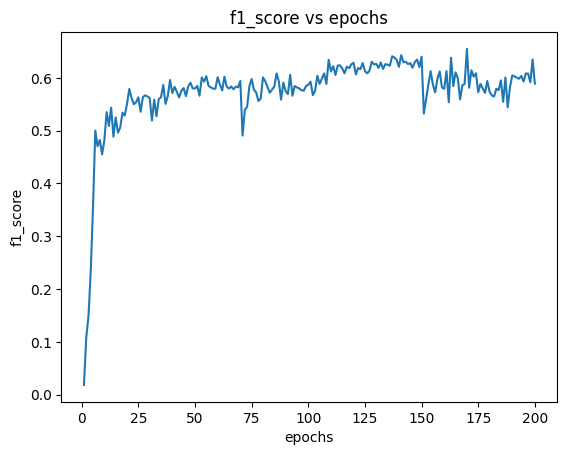

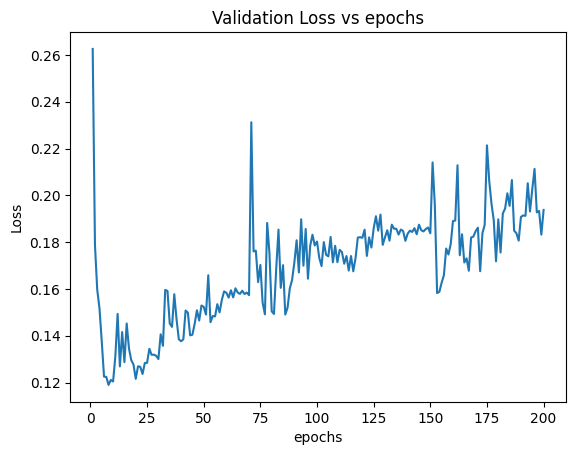

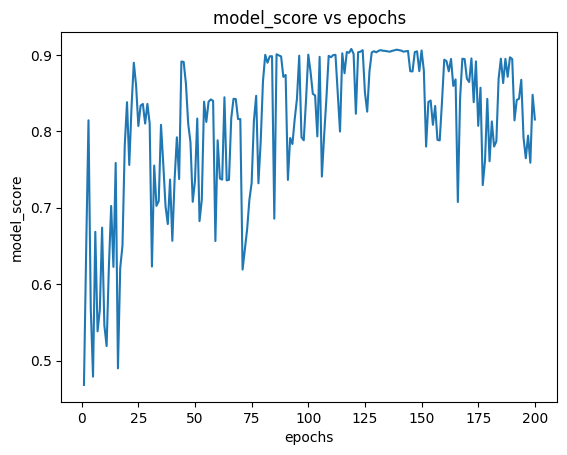

In [6]:
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,k+1), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

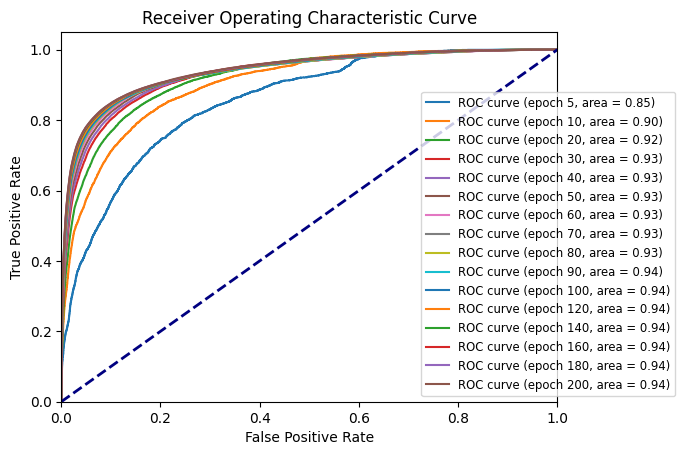

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [8]:
# model.eval()
# val_preds, val_labels = [], []
# heatmap_images = []  # Store heatmap images for positive samples with AUC score < 1
# with torch.no_grad():
#     for images, labels in tqdm(val_dataloader):
#         images, labels = images.to(device), labels.to(device)
            
#         # Forward pass
#         outputs = model(images)
#         outputs = torch.sigmoid(outputs)
        
#         # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
#         val_preds += outputs.tolist()
#         val_labels += labels.tolist()

#         # Generate heatmaps for positive samples with AUC score < 1
#         for idx, label in enumerate(labels):
#             if roc_auc_score([label.item()], [outputs[idx].item()]) < 1:
#                 # Convert the image to numpy array and normalize
#                 image = images[idx].cpu().numpy().transpose(1, 2, 0)
#                 image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#                 # Resize the image to match the input size of the model
#                 image = cv2.resize(image, (image_size, image_size))

#                 # Generate the heatmap
#                 heatmap = cam_generate(model, image, label.item())

#                 # Normalize the heatmap
#                 heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#                 # Store the heatmap image
#                 heatmap_images.append(heatmap)

# val_labels = np.array(val_labels)
# val_preds = np.array(val_preds)
# threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# # Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
# metrics_dict = {}
# for label in range(num_classes):
#     precision, recall, _ = precision_recall_curve(val_labels[:, label], thresholded_val_preds[:, label])
#     auc = roc_auc_score(val_labels[:, label], val_preds[:, label])
#     f1 = f1_score(val_labels[:, label], thresholded_val_preds[:, label], average='binary', zero_division=1)
#     metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}

# # Print the dictionary in tabular format using the tabulate library
# headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
# table = []
# for label in range(num_classes):
#     row = [label]
#     for metric in ['Precision', 'Recall', 'F1', 'AUC']:
#         values = metrics_dict[label][metric]
#         if values.size > 0:
#             value_str = '{:.4f}'.format(values.mean(), values.max())
#         else:
#             value_str = '0.00'
#         row.append(value_str)
#     table.append(row)

# print(tabulate(table, headers=headers))

# # Visualize the heatmap images
# for idx, heatmap_image in enumerate(heatmap_images):
#     cv2.imshow(f"Heatmap {idx}", heatmap_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]

  Label    Precision    Recall    F1     AUC
-------  -----------  --------  ----  ------
      0       0.35      0.3333     0  0.9474
      1       0.525     0.5        0  0.8421
      2       0.525     0.5        0  1
      3       0.35      0.3333     0  0.8947
      4       0.525     0.5        0  0.7895
      5       0.6833    0.6667     1  1
      6       0.6833    0.6667     1  1
      7       0.525     0.5        0  0.9474
      8       0.35      0.3333     0  0.8421
      9       0.6833    0.6667     1  1
     10       0.6833    0.6667     1  1
     11       0.6833    0.6667     1  1
     12       0.525     0.5        0  1
     13       0.6833    0.6667     1  1
     14       0.525     0.5        0  0.9474
     15       0.6833    0.6667     1  1
     16       0.35      0.3333     0  0.9474
     17       0.35      0.3333     0  0.9474
     18       0.6833    0.6667     1  1
     19       0.7       0.6667     1  1
